## Notebook 1B: Multivariate regression of energy consumption

**1. Prepare Problem**

In [37]:
# a) Load libraries
import pandas as pd
from pandas import set_option
from pandas import DataFrame

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow import keras
from keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasRegressor
from tensorflow.keras.models import Sequential
from keras.layers import BatchNormalization, Dropout, Dense

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import *
from sklearn.ensemble import *
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_val_score

from pickle import dump

In [36]:
import sklearn
print('scikit-learn version:', sklearn.__version__)

scikit-learn version: 1.5.2


In [2]:
import tensorflow as tf
from tensorflow.python.client import device_lib
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [3]:
# b) Load dataset
# Load and view each file in the dataset
data = pd.read_csv('EPB_data.csv', header=0)
print(data.shape)
display(data.head(10))
print(data.dtypes)

(768, 8)


,Relative Compactness,Surface Area,Roof Area,Overall Height,Orientation,Glazing Area,Glazing Area Distribution,Heating Load
0,0.98,514.5,110.25,7.0,2,0.0,0,15.55
1,0.98,514.5,110.25,7.0,3,0.0,0,15.55
2,0.98,514.5,110.25,7.0,4,0.0,0,15.55
3,0.98,514.5,110.25,7.0,5,0.0,0,15.55
4,0.90,563.5,122.50,7.0,2,0.0,0,20.84
5,0.90,563.5,122.50,7.0,3,0.0,0,21.46
6,0.90,563.5,122.50,7.0,4,0.0,0,20.71
7,0.90,563.5,122.50,7.0,5,0.0,0,19.68
8,0.86,588.0,147.00,7.0,2,0.0,0,19.50
9,0.86,588.0,147.00,7.0,3,0.0,0,19.95


Relative Compactness         float64
Surface Area                 float64
Roof Area                    float64
Overall Height               float64
Orientation                    int64
Glazing Area                 float64
Glazing Area Distribution      int64
Heating Load                 float64
dtype: object


One of the approach in optimizing building energy efficiency is to minimize total energy consumption, which is the sum of heating and cooling.

In [4]:
# Define features and label
X = data.drop(columns=['Heating Load'], axis = 1)
y = data[['Heating Load']]
print(X.shape, y.shape)

(768, 7) (768, 1)


**2. Dataset summary**

In [5]:
# a) Descriptive statistics
set_option("display.precision", 3)
print(data.describe())

       Relative Compactness  Surface Area  Roof Area  Overall Height  \
count               768.000       768.000    768.000         768.000   
mean                  0.764       671.708    176.604           5.250   
std                   0.106        88.086     45.166           1.751   
min                   0.620       514.500    110.250           3.500   
25%                   0.682       606.375    140.875           3.500   
50%                   0.750       673.750    183.750           5.250   
75%                   0.830       741.125    220.500           7.000   
max                   0.980       808.500    220.500           7.000   

       Orientation  Glazing Area  Glazing Area Distribution  Heating Load  
count      768.000       768.000                    768.000       768.000  
mean         3.500         0.234                      2.812        22.307  
std          1.119         0.133                      1.551        10.090  
min          2.000         0.000               

In [6]:
# checking categorical features
cat_features = data.select_dtypes(include='O').keys()
# display variabels
cat_features

Index([], dtype='object')

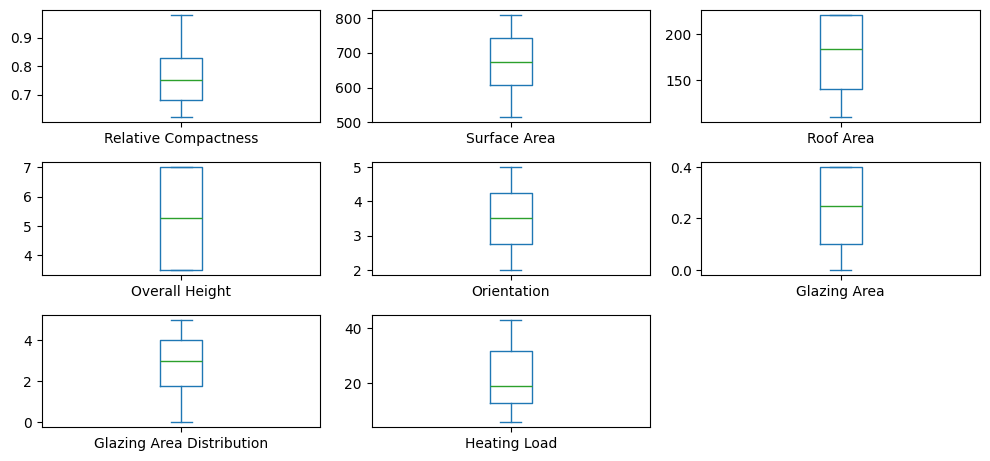

In [7]:
# b) Data visualizations
# Box and Whisker Plots of a few features

plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.autolayout"] = True

raw_plot = pd.DataFrame(data)
raw_plot.plot(kind='box', subplots=True, layout=(4,3), sharex=False, sharey=False)
plt.show()

We can see the data skewed to high values in relative compactness, roof area, glazing area, and cooling load.

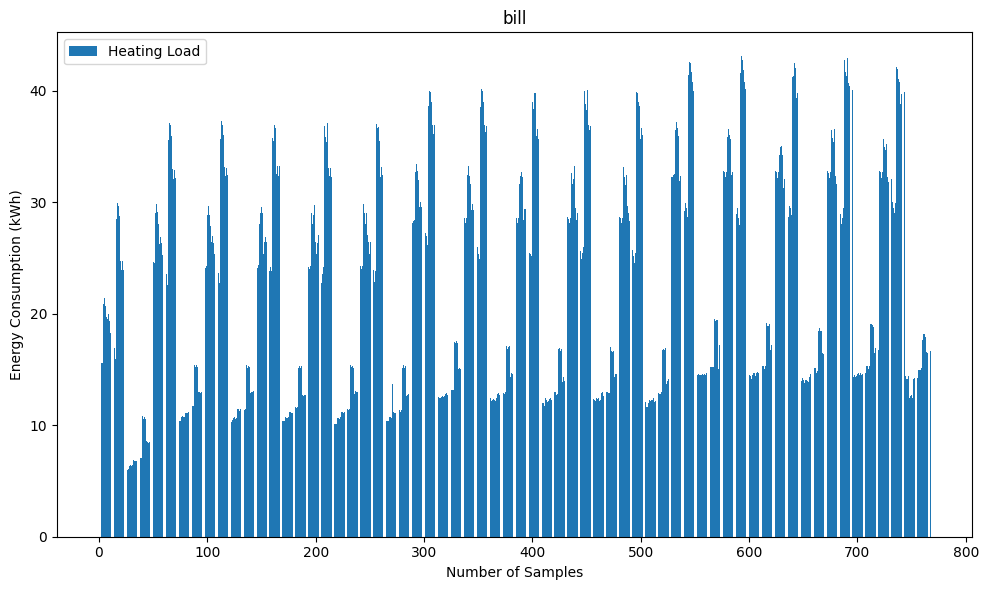

In [8]:
# create the stack bar chart of Heating and Cooling Load
fig, ax = plt.subplots()
ax.bar(np.arange(len(data['Heating Load'])), data['Heating Load'], label='Heating Load')

# add labels, title and legend
ax.set_xlabel('Number of Samples')
ax.set_ylabel('Energy Consumption (kWh)')
ax.set_title('bill')
ax.legend()

# show the plot
plt.show()

The data displays a cyclical pattern that may have resulted from the measurements taken on weekdays (with longer hours) and weekends.

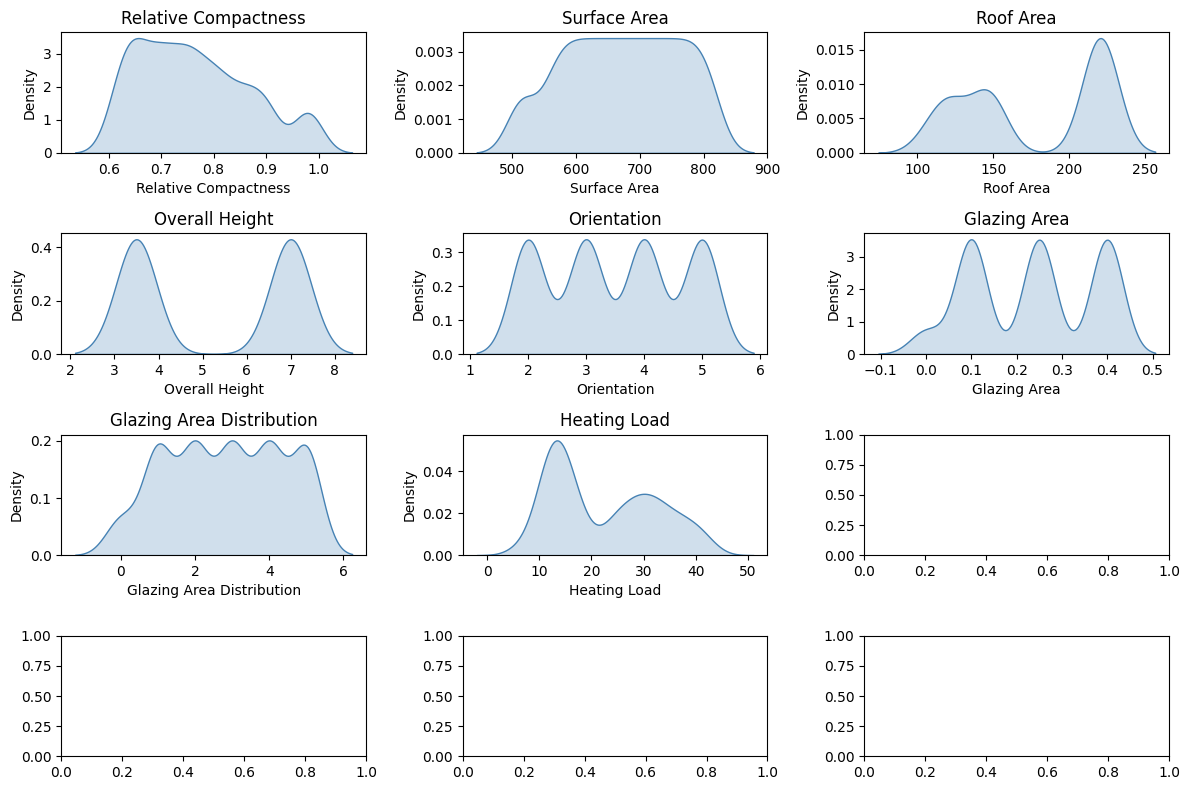

In [9]:
# Create a figure with subplots
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(12, 8))

# Flatten the axes array to simplify plotting
axes = axes.flatten()

# Loop through each feature and create a density plot
for i, feature in enumerate(raw_plot.columns):
    sns.kdeplot(raw_plot[feature], ax=axes[i], color='steelblue', fill=True)
    axes[i].set_title(feature)

# Adjust the layout and spacing of the subplots
fig.tight_layout()

plt.show()

The dataset seems to be complex as most of features exhibit non-Gaussian distributions, except for the Surface Area. There are several factors that could cause non-Gaussian distributions, including outliers, measurement errors, or the inherent characteristics of the building designs.

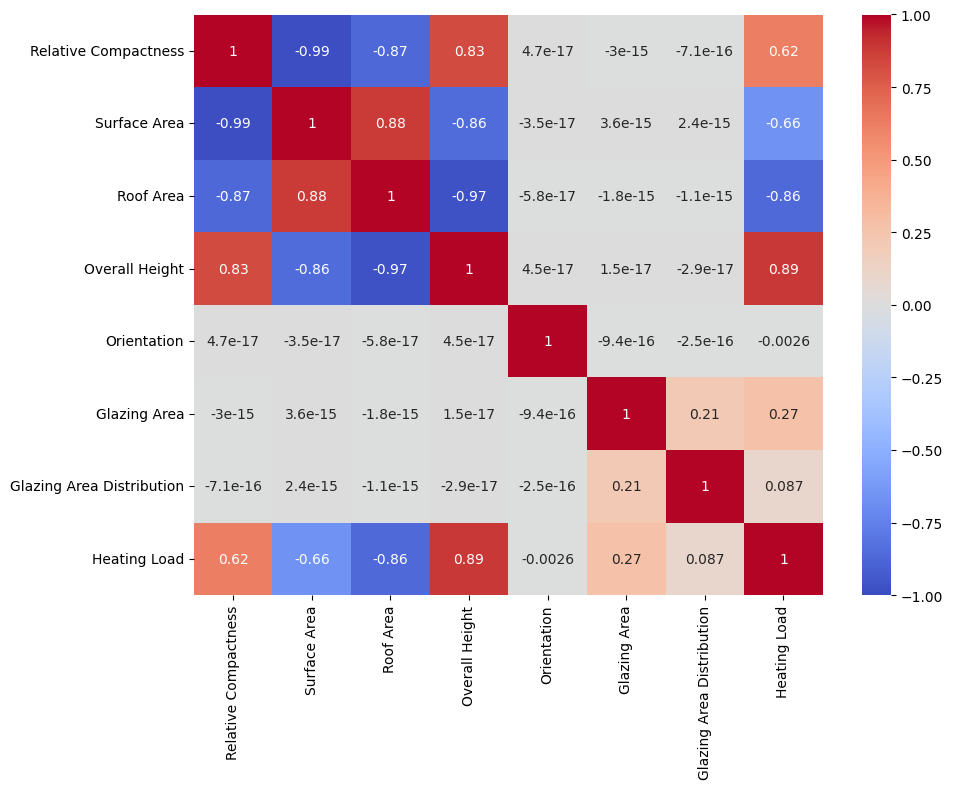

In [10]:
# correlation matrix between all pairs of attributes
corr_matrix = data.corr(method='pearson')

# Create a heatmap using seaborn
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix, vmin=-1, vmax=1, annot=True, cmap="coolwarm", ax=ax)

plt.show()

According to the correlation matrix, the heating and cooling loads, as well as energy consumption, exhibit strong correlations with the overall height, orientation, and to some extent, the surface area. The orientation is considered to be an uncertain factor in building design due to limited choices compared to other variables and it plays a significant role in determining the energy efficiency of a building.

**3. Prepare Data**

In [11]:
# a) Data Cleaning
# summarize the number of unique values in each column
print(data.nunique())

Relative Compactness          12
Surface Area                  12
Roof Area                      4
Overall Height                 2
Orientation                    4
Glazing Area                   4
Glazing Area Distribution      6
Heating Load                 586
dtype: int64


In [12]:
# Identify columns with missing values and count the number of missing values
data.columns[data.isnull().any()]
print(data.isnull().sum())

Relative Compactness         0
Surface Area                 0
Roof Area                    0
Overall Height               0
Orientation                  0
Glazing Area                 0
Glazing Area Distribution    0
Heating Load                 0
dtype: int64


It is necessary to eliminate outliers in numerical data columns to improve the accuracy of training and validation processes. This can be done by determining the correlation between these columns and the target variable, identifying columns with low correlation, and then filtering out values that fall outside of the lower and upper bounds.

In [13]:
# calculate the correlation between numerical columns and target variables
corr_matrix = data.select_dtypes(include=np.number).corrwith(data['Heating Load']).sort_values(ascending=False)

# filter columns with low correlation
corr_threshold = 0.05
low_corr_columns = corr_matrix[corr_matrix.abs() < corr_threshold].index

# remove outliers from numerical columns with low correlation
for column in low_corr_columns:
    lower = data[column].quantile(0.01)
    upper = data[column].quantile(0.99)
    data[column] = data[column].clip(lower, upper)

In [14]:
# calculate the correlation between numerical columns and target variables
corr_matrix = data.select_dtypes(include=np.number).corrwith(data['Heating Load']).sort_values(ascending=False)

# filter columns with low correlation
corr_threshold = 0.05
low_corr_columns = corr_matrix[corr_matrix.abs() < corr_threshold].index

# remove outliers from numerical columns with low correlation
for column in low_corr_columns:
    lower = data[column].quantile(0.01)
    upper = data[column].quantile(0.99)
    data[column] = data[column].clip(lower, upper)

In [15]:
# b) Split-out dataset into train and validation sets

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=1)

print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

(576, 7) (576, 1) (192, 7) (192, 1)


In [16]:
# c) Data Transforms
# Standardize the dataset by rescaling the distribution of values

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.fit_transform(X_val)

**4. Evaluate Algorithms**

In [39]:
# a) Spot check algorithms using cross-validation technique
num_folds = 8
seed = 8

# Select 5 most popular linear and tree-based algorithms for evaluation
models = []
models.append(('LR', LinearRegression()))
models.append(('EN', ElasticNet()))
models.append(('RF', RandomForestRegressor()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('SVR', MultiOutputRegressor(SVR(gamma='auto'))))
models.append(('XGBOOST', GradientBoostingRegressor()))
models.append(('ADABOOST', AdaBoostRegressor()))

In [41]:
# Neural Network algorithms
# create keras Sequential model
def baseline_model():
    model = Sequential()
    model.add(Dense(300, input_shape = (7, ), activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    model.add(Dense(200, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    model.add(Dense(100, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    model.add(Dense(1))
    # Compile model
    model.compile(optimizer = 'adam',
                loss = 'mean_squared_error',
                metrics=['mse'])
    return model

# Build model
model_NN = baseline_model()
models.append(('NN', model_NN))

In [42]:
# Define a callback for early stopping if the validation loss does not improve for 10 consecutive
# epochs (patience=10).
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

In [43]:
results = []
alg_names = []

# Initialize the KerasRegressor estimator with early stopping
estimator = KerasRegressor(model=model_NN, batch_size=128, verbose=1, callbacks=[early_stopping])

for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)

    # modify loop for NN
    if name != 'NN':
        cvs = cross_val_score(model, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error')
    else:
        validation_data = (X_val, y_val)
        cvs = cross_val_score(estimator, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error', fit_params={'validation_data': validation_data, 'epochs': 150})

    results.append(cvs)
    alg_names.append(name)
    output = "%s: %f (%f)" % (name, cvs.mean(), cvs.std())
    print(output)

LR: -8.213543 (1.870210)
EN: -48.528127 (10.471758)


c:\Users\pkastner\anaconda3\envs\24-fa-energyinbuildings-commercial\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\pkastner\anaconda3\envs\24-fa-energyinbuildings-commercial\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\pkastner\anaconda3\envs\24-fa-energyinbuildings-commercial\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\pkastner\anaconda3\envs\24-fa-energyinbuildings-commercial

RF: -0.350793 (0.163337)
KNN: -9.304752 (2.608518)
SVR: -12.495847 (3.518934)


c:\Users\pkastner\anaconda3\envs\24-fa-energyinbuildings-commercial\Lib\site-packages\sklearn\ensemble\_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
c:\Users\pkastner\anaconda3\envs\24-fa-energyinbuildings-commercial\Lib\site-packages\sklearn\ensemble\_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
c:\Users\pkastner\anaconda3\envs\24-fa-energyinbuildings-commercial\Lib\site-packages\sklearn\ensemble\_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still

XGBOOST: -0.259107 (0.102064)
ADABOOST: -3.890942 (0.447315)
Epoch 1/150


c:\Users\pkastner\anaconda3\envs\24-fa-energyinbuildings-commercial\Lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
c:\Users\pkastner\anaconda3\envs\24-fa-energyinbuildings-commercial\Lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 30 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 580.5533 - mse: 580.5533 - val_loss: 637.4835 - val_mse: 637.4835
Epoch 2/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 509.8827 - mse: 509.8827 - val_loss: 627.2455 - val_mse: 627.2455
Epoch 3/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 503.2827 - mse: 503.2827 - val_loss: 617.9890 - val_mse: 617.9890
Epoch 4/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 500.1013 - mse: 500.1013 - val_loss: 609.7592 - val_mse: 609.7592
Epoch 5/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 477.9003 - mse: 477.9003 - val_loss: 602.4727 - val_mse: 602.4727
Epoch 6/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 474.3702 - mse: 474.3702 - val_loss: 595.4004 - val_mse: 595.4004
Epoch 7/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 470.5924 - mse: 470.5924 - val_loss: 589.3089 - val_mse: 589.3089
Epoch 8/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 468.0009 - mse: 468.0009 - val_loss: 584.0992 - val_mse: 584.0992
Epoch 9/150
4/4 ━━━━━━━━━━━

c:\Users\pkastner\anaconda3\envs\24-fa-energyinbuildings-commercial\Lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 30 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 559.0746 - mse: 559.0746 - val_loss: 639.2108 - val_mse: 639.2108
Epoch 2/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 522.4938 - mse: 522.4938 - val_loss: 630.7801 - val_mse: 630.7801
Epoch 3/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 512.9711 - mse: 512.9711 - val_loss: 621.6349 - val_mse: 621.6349
Epoch 4/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 517.3731 - mse: 517.3731 - val_loss: 612.5957 - val_mse: 612.5957
Epoch 5/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 507.6018 - mse: 507.6018 - val_loss: 604.5091 - val_mse: 604.5091
Epoch 6/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 489.4625 - mse: 489.4625 - val_loss: 597.2656 - val_mse: 597.2656
Epoch 7/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 492.4326 - mse: 492.4326 - val_loss: 590.0118 - val_mse: 590.0118
Epoch 8/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 484.3656 - mse: 484.3656 - val_loss: 583.0245 - val_mse: 583.0245
Epoch 9/150
4/4 ━━━━━━━━━━━

c:\Users\pkastner\anaconda3\envs\24-fa-energyinbuildings-commercial\Lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 30 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 568.2942 - mse: 568.2942 - val_loss: 638.7994 - val_mse: 638.7994
Epoch 2/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 532.3098 - mse: 532.3098 - val_loss: 630.0966 - val_mse: 630.0966
Epoch 3/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 499.1852 - mse: 499.1852 - val_loss: 621.2381 - val_mse: 621.2381
Epoch 4/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 479.4838 - mse: 479.4838 - val_loss: 612.4820 - val_mse: 612.4820
Epoch 5/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 487.8757 - mse: 487.8757 - val_loss: 603.7763 - val_mse: 603.7763
Epoch 6/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 500.5931 - mse: 500.5931 - val_loss: 595.7431 - val_mse: 595.7431
Epoch 7/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 467.7187 - mse: 467.7187 - val_loss: 588.3228 - val_mse: 588.3228
Epoch 8/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 483.9819 - mse: 483.9819 - val_loss: 581.3865 - val_mse: 581.3865
Epoch 9/150
4/4 ━━━━━━━━━━━

c:\Users\pkastner\anaconda3\envs\24-fa-energyinbuildings-commercial\Lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 30 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 572.0038 - mse: 572.0038 - val_loss: 638.8983 - val_mse: 638.8983
Epoch 2/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 548.9498 - mse: 548.9498 - val_loss: 630.0166 - val_mse: 630.0166
Epoch 3/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 515.1227 - mse: 515.1227 - val_loss: 620.8410 - val_mse: 620.8410
Epoch 4/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 506.4086 - mse: 506.4086 - val_loss: 612.3634 - val_mse: 612.3634
Epoch 5/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 489.2218 - mse: 489.2218 - val_loss: 604.0212 - val_mse: 604.0212
Epoch 6/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 501.4382 - mse: 501.4382 - val_loss: 596.7363 - val_mse: 596.7363
Epoch 7/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 503.6502 - mse: 503.6502 - val_loss: 589.9239 - val_mse: 589.9239
Epoch 8/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 483.2012 - mse: 483.2012 - val_loss: 584.0925 - val_mse: 584.0925
Epoch 9/150
4/4 ━━━━━━━━━━━

c:\Users\pkastner\anaconda3\envs\24-fa-energyinbuildings-commercial\Lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 30 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - loss: 556.6193 - mse: 556.6193 - val_loss: 637.5906 - val_mse: 637.5906
Epoch 2/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 541.4402 - mse: 541.4402 - val_loss: 628.1725 - val_mse: 628.1725
Epoch 3/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 531.6130 - mse: 531.6129 - val_loss: 619.2525 - val_mse: 619.2525
Epoch 4/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 505.7885 - mse: 505.7885 - val_loss: 610.7275 - val_mse: 610.7275
Epoch 5/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 490.0121 - mse: 490.0121 - val_loss: 602.2853 - val_mse: 602.2853
Epoch 6/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 488.1174 - mse: 488.1174 - val_loss: 594.2580 - val_mse: 594.2580
Epoch 7/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 489.7162 - mse: 489.7162 - val_loss: 587.0567 - val_mse: 587.0567
Epoch 8/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 495.3093 - mse: 495.3093 - val_loss: 580.2710 - val_mse: 580.2710
Epoch 9/150
4/4 ━━━━━━━━━━

c:\Users\pkastner\anaconda3\envs\24-fa-energyinbuildings-commercial\Lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 30 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 550.4245 - mse: 550.4245 - val_loss: 638.3189 - val_mse: 638.3189
Epoch 2/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 549.1014 - mse: 549.1014 - val_loss: 628.7205 - val_mse: 628.7205
Epoch 3/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 518.3652 - mse: 518.3652 - val_loss: 619.8090 - val_mse: 619.8090
Epoch 4/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 492.3522 - mse: 492.3522 - val_loss: 610.8633 - val_mse: 610.8633
Epoch 5/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 481.6876 - mse: 481.6876 - val_loss: 602.4231 - val_mse: 602.4231
Epoch 6/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 466.7884 - mse: 466.7884 - val_loss: 593.9180 - val_mse: 593.9180
Epoch 7/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 465.6987 - mse: 465.6987 - val_loss: 586.5274 - val_mse: 586.5274
Epoch 8/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 482.9327 - mse: 482.9327 - val_loss: 579.7792 - val_mse: 579.7792
Epoch 9/150
4/4 ━━━━━━━━━━━

c:\Users\pkastner\anaconda3\envs\24-fa-energyinbuildings-commercial\Lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 30 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 557.9491 - mse: 557.9491 - val_loss: 638.0100 - val_mse: 638.0100
Epoch 2/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 522.5222 - mse: 522.5222 - val_loss: 628.5805 - val_mse: 628.5805
Epoch 3/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 513.2788 - mse: 513.2788 - val_loss: 619.1399 - val_mse: 619.1399
Epoch 4/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 507.1764 - mse: 507.1764 - val_loss: 609.9136 - val_mse: 609.9136
Epoch 5/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 489.9874 - mse: 489.9874 - val_loss: 601.1550 - val_mse: 601.1550
Epoch 6/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 480.2613 - mse: 480.2613 - val_loss: 592.4153 - val_mse: 592.4153
Epoch 7/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 482.7944 - mse: 482.7944 - val_loss: 584.5774 - val_mse: 584.5774
Epoch 8/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 485.6952 - mse: 485.6952 - val_loss: 577.6948 - val_mse: 577.6948
Epoch 9/150
4/4 ━━━━━━━━━━━

c:\Users\pkastner\anaconda3\envs\24-fa-energyinbuildings-commercial\Lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 30 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 561.3636 - mse: 561.3636 - val_loss: 639.0649 - val_mse: 639.0649
Epoch 2/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 500.6355 - mse: 500.6355 - val_loss: 629.5554 - val_mse: 629.5554
Epoch 3/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 510.4482 - mse: 510.4482 - val_loss: 620.5637 - val_mse: 620.5637
Epoch 4/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 488.9349 - mse: 488.9349 - val_loss: 611.9481 - val_mse: 611.9481
Epoch 5/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 462.2888 - mse: 462.2888 - val_loss: 603.4357 - val_mse: 603.4357
Epoch 6/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 486.5767 - mse: 486.5767 - val_loss: 595.3209 - val_mse: 595.3209
Epoch 7/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 478.1197 - mse: 478.1197 - val_loss: 587.8565 - val_mse: 587.8565
Epoch 8/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 476.9735 - mse: 476.9735 - val_loss: 581.1548 - val_mse: 581.1548
Epoch 9/150
4/4 ━━━━━━━━━━━

c:\Users\pkastner\anaconda3\envs\24-fa-energyinbuildings-commercial\Lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
c:\Users\pkastner\anaconda3\envs\24-fa-energyinbuildings-commercial\Lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 30 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 555.2772 - mse: 555.2772 - val_loss: 637.3485 - val_mse: 637.3485
Epoch 2/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 508.7550 - mse: 508.7550 - val_loss: 627.1016 - val_mse: 627.1016
Epoch 3/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 473.4775 - mse: 473.4775 - val_loss: 617.9272 - val_mse: 617.9272
Epoch 4/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 492.7091 - mse: 492.7091 - val_loss: 609.8644 - val_mse: 609.8644
Epoch 5/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 482.0607 - mse: 482.0607 - val_loss: 601.9958 - val_mse: 601.9958
Epoch 6/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 475.0065 - mse: 475.0065 - val_loss: 595.1866 - val_mse: 595.1866
Epoch 7/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 484.6907 - mse: 484.6907 - val_loss: 589.2375 - val_mse: 589.2375
Epoch 8/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 480.1293 - mse: 480.1293 - val_loss: 583.7266 - val_mse: 583.7266
Epoch 9/150
4/4 ━━━━━━━━━━━

c:\Users\pkastner\anaconda3\envs\24-fa-energyinbuildings-commercial\Lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 30 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 585.8719 - mse: 585.8719 - val_loss: 638.8546 - val_mse: 638.8546
Epoch 2/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 533.3740 - mse: 533.3740 - val_loss: 629.0964 - val_mse: 629.0964
Epoch 3/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 548.0897 - mse: 548.0897 - val_loss: 620.6108 - val_mse: 620.6108
Epoch 4/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 491.2402 - mse: 491.2402 - val_loss: 611.9649 - val_mse: 611.9649
Epoch 5/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 509.0880 - mse: 509.0880 - val_loss: 603.0811 - val_mse: 603.0811
Epoch 6/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 496.6780 - mse: 496.6780 - val_loss: 594.9446 - val_mse: 594.9446
Epoch 7/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 492.4106 - mse: 492.4106 - val_loss: 587.4279 - val_mse: 587.4279
Epoch 8/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 469.8333 - mse: 469.8333 - val_loss: 580.0574 - val_mse: 580.0574
Epoch 9/150
4/4 ━━━━━━━━━━━

c:\Users\pkastner\anaconda3\envs\24-fa-energyinbuildings-commercial\Lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 30 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 549.9979 - mse: 549.9979 - val_loss: 639.7170 - val_mse: 639.7170
Epoch 2/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 521.8034 - mse: 521.8034 - val_loss: 630.9156 - val_mse: 630.9156
Epoch 3/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 502.7334 - mse: 502.7334 - val_loss: 622.0531 - val_mse: 622.0531
Epoch 4/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 501.4209 - mse: 501.4209 - val_loss: 614.2027 - val_mse: 614.2027
Epoch 5/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 470.5538 - mse: 470.5538 - val_loss: 606.7180 - val_mse: 606.7180
Epoch 6/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 480.7955 - mse: 480.7955 - val_loss: 599.5815 - val_mse: 599.5815
Epoch 7/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 478.7733 - mse: 478.7733 - val_loss: 592.3957 - val_mse: 592.3957
Epoch 8/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 505.0649 - mse: 505.0649 - val_loss: 585.5386 - val_mse: 585.5386
Epoch 9/150
4/4 ━━━━━━━━━━━

c:\Users\pkastner\anaconda3\envs\24-fa-energyinbuildings-commercial\Lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 30 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 593.1879 - mse: 593.1879 - val_loss: 638.8135 - val_mse: 638.8135
Epoch 2/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 513.7395 - mse: 513.7395 - val_loss: 629.4566 - val_mse: 629.4566
Epoch 3/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 509.0127 - mse: 509.0127 - val_loss: 620.1161 - val_mse: 620.1161
Epoch 4/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 484.8356 - mse: 484.8356 - val_loss: 611.2542 - val_mse: 611.2542
Epoch 5/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 490.7007 - mse: 490.7007 - val_loss: 602.6700 - val_mse: 602.6700
Epoch 6/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 494.4724 - mse: 494.4724 - val_loss: 594.5655 - val_mse: 594.5655
Epoch 7/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 474.2695 - mse: 474.2695 - val_loss: 588.0869 - val_mse: 588.0869
Epoch 8/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 476.3141 - mse: 476.3141 - val_loss: 581.9880 - val_mse: 581.9880
Epoch 9/150
4/4 ━━━━━━━━━━━

c:\Users\pkastner\anaconda3\envs\24-fa-energyinbuildings-commercial\Lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 30 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 587.6464 - mse: 587.6464 - val_loss: 637.5158 - val_mse: 637.5158
Epoch 2/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 551.5407 - mse: 551.5407 - val_loss: 627.1761 - val_mse: 627.1761
Epoch 3/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 520.0867 - mse: 520.0867 - val_loss: 617.7695 - val_mse: 617.7695
Epoch 4/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 507.4361 - mse: 507.4361 - val_loss: 609.0474 - val_mse: 609.0474
Epoch 5/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 505.2472 - mse: 505.2472 - val_loss: 600.3786 - val_mse: 600.3786
Epoch 6/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 489.5985 - mse: 489.5985 - val_loss: 592.2274 - val_mse: 592.2274
Epoch 7/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 487.2431 - mse: 487.2431 - val_loss: 584.9554 - val_mse: 584.9554
Epoch 8/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 496.1186 - mse: 496.1186 - val_loss: 578.2281 - val_mse: 578.2281
Epoch 9/150
4/4 ━━━━━━━━━━━

c:\Users\pkastner\anaconda3\envs\24-fa-energyinbuildings-commercial\Lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 30 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 541.3972 - mse: 541.3972 - val_loss: 638.0005 - val_mse: 638.0005
Epoch 2/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 504.3070 - mse: 504.3070 - val_loss: 628.2452 - val_mse: 628.2452
Epoch 3/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 503.8214 - mse: 503.8214 - val_loss: 618.5836 - val_mse: 618.5836
Epoch 4/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 483.0988 - mse: 483.0988 - val_loss: 609.6539 - val_mse: 609.6539
Epoch 5/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 499.7786 - mse: 499.7786 - val_loss: 601.0290 - val_mse: 601.0290
Epoch 6/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 474.6372 - mse: 474.6372 - val_loss: 593.1733 - val_mse: 593.1733
Epoch 7/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 483.6743 - mse: 483.6743 - val_loss: 586.1547 - val_mse: 586.1547
Epoch 8/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 475.1699 - mse: 475.1699 - val_loss: 579.9820 - val_mse: 579.9820
Epoch 9/150
4/4 ━━━━━━━━━━━

c:\Users\pkastner\anaconda3\envs\24-fa-energyinbuildings-commercial\Lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 30 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 582.4434 - mse: 582.4434 - val_loss: 638.9756 - val_mse: 638.9756
Epoch 2/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 539.6991 - mse: 539.6991 - val_loss: 629.5067 - val_mse: 629.5067
Epoch 3/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 506.5976 - mse: 506.5976 - val_loss: 619.4145 - val_mse: 619.4145
Epoch 4/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 516.6082 - mse: 516.6082 - val_loss: 609.8749 - val_mse: 609.8749
Epoch 5/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 503.1101 - mse: 503.1101 - val_loss: 600.9976 - val_mse: 600.9976
Epoch 6/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 489.1741 - mse: 489.1741 - val_loss: 592.1275 - val_mse: 592.1275
Epoch 7/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 499.8089 - mse: 499.8089 - val_loss: 584.2126 - val_mse: 584.2126
Epoch 8/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 476.6618 - mse: 476.6618 - val_loss: 577.3098 - val_mse: 577.3098
Epoch 9/150
4/4 ━━━━━━━━━━━

c:\Users\pkastner\anaconda3\envs\24-fa-energyinbuildings-commercial\Lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 30 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 562.8902 - mse: 562.8902 - val_loss: 639.4110 - val_mse: 639.4110
Epoch 2/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 523.4122 - mse: 523.4122 - val_loss: 630.9485 - val_mse: 630.9485
Epoch 3/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 484.1221 - mse: 484.1221 - val_loss: 622.1319 - val_mse: 622.1319
Epoch 4/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 493.9341 - mse: 493.9341 - val_loss: 613.7929 - val_mse: 613.7929
Epoch 5/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 484.0977 - mse: 484.0977 - val_loss: 605.4479 - val_mse: 605.4479
Epoch 6/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 476.9922 - mse: 476.9922 - val_loss: 597.2702 - val_mse: 597.2702
Epoch 7/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 482.4515 - mse: 482.4515 - val_loss: 590.1164 - val_mse: 590.1164
Epoch 8/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 452.5510 - mse: 452.5510 - val_loss: 583.4504 - val_mse: 583.4504
Epoch 9/150
4/4 ━━━━━━━━━━━

Epoch 1/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 569.6230 - mse: 569.6230 - val_loss: 636.8139 - val_mse: 636.8139
Epoch 2/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 523.3976 - mse: 523.3976 - val_loss: 626.5452 - val_mse: 626.5452
Epoch 3/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 493.0750 - mse: 493.0750 - val_loss: 616.6863 - val_mse: 616.6863
Epoch 4/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 488.7549 - mse: 488.7549 - val_loss: 606.7084 - val_mse: 606.7084
Epoch 5/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 493.5439 - mse: 493.5439 - val_loss: 596.7647 - val_mse: 596.7647
Epoch 6/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 490.2109 - mse: 490.2109 - val_loss: 587.1424 - val_mse: 587.1424
Epoch 7/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 489.1364 - mse: 489.1364 - val_loss: 578.7369 - val_mse: 578.7369
Epoch 8/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 488.8048 - mse: 488.8048 - val_loss: 570.9122 - val_mse: 570.9122
Epoch 9/500
5/5

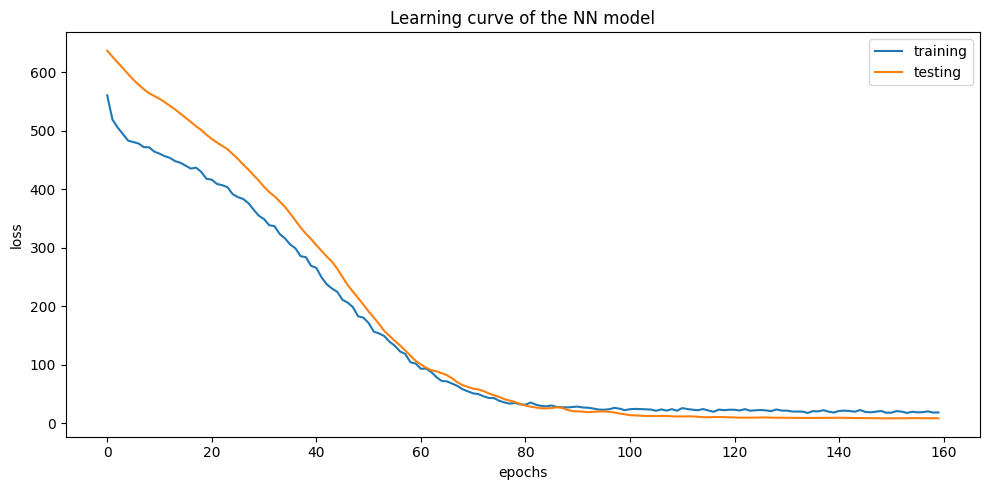

In [45]:
# Plot learning curve of NN model
history = model_NN.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=500, batch_size=128, callbacks=[early_stopping])

plt.figure(figsize = (10, 5))
plt.plot(history.history['loss'], label = 'training')
plt.plot(history.history['val_loss'], label = 'testing')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Learning curve of the NN model')
plt.legend()

In [49]:
display(pd.DataFrame(results))

,0,1,2,3,4,5,6,7
0,-5.619,-11.217,-8.893,-6.969,-6.699,-8.609,-6.986,-10.715
1,-35.356,-53.013,-63.818,-43.076,-42.443,-57.107,-34.400,-59.012
2,-0.245,-0.236,-0.314,-0.731,-0.183,-0.301,-0.334,-0.463
3,-7.020,-12.859,-11.114,-6.642,-6.138,-8.877,-8.555,-13.234
4,-8.854,-13.257,-15.512,-8.223,-10.383,-15.876,-9.579,-18.281
5,-0.205,-0.171,-0.241,-0.362,-0.226,-0.190,-0.193,-0.486
6,-3.116,-4.067,-3.339,-4.162,-3.781,-3.821,-4.503,-4.338
7,-6.515,-10.476,-9.645,-4.851,-8.196,-7.726,-7.101,-13.027
8,-5.975,-9.466,-8.764,-4.815,-6.247,-8.176,-6.685,-11.886


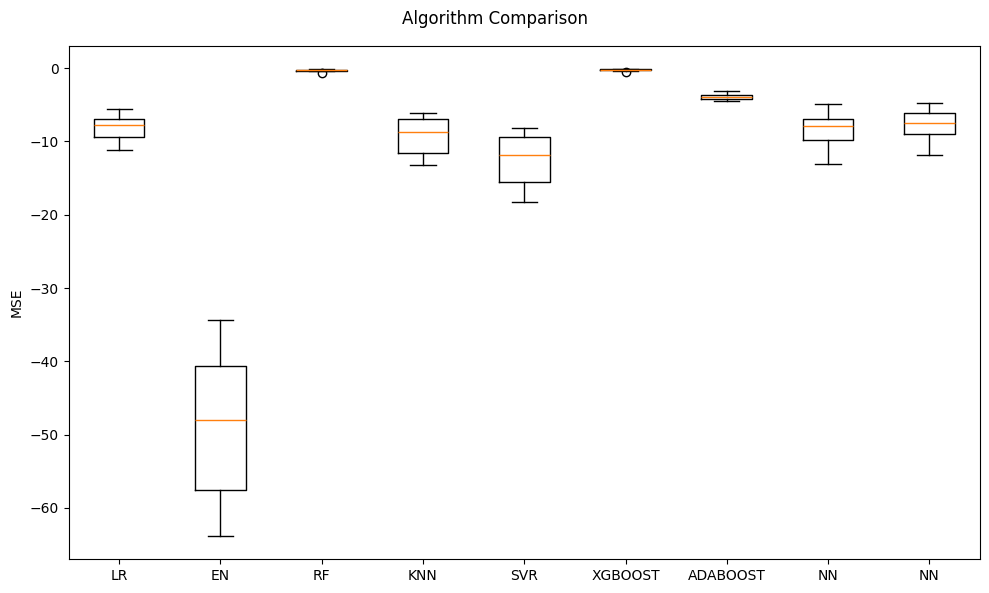

In [46]:
# b) Compare algorithms and the NN model
# Distribution of accuracy values calculated across 8 cross-validation folds.
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot()
plt.boxplot(results)
ax.set_xticklabels(alg_names)
plt.ylabel("MSE")
plt.show()

The Random Forest algorithm demonstrated superior performance compared to the other five machine learning algorithms and the neural network model.

In a regression problem, it is common to use the mean error as a measure of validation. This is done by first calculating the mean absolute error (MAE) of the test data with the mean of dataset, and then calculating the MAE of the test data with the predicted data. 

In [23]:
# Evaluate performance of Random Forest algorithm on validation data
model_RF = RandomForestRegressor()
model_RF.fit(X_train, y_train)
y_pred_RF = model_RF.predict(X_val)
mae_pred_RF = mean_absolute_error(y_val, y_pred_RF)
print("Mean Absolute Error of predicted data: ", mae_pred_RF)

Mean Absolute Error of predicted data:  0.38828906250000017


c:\Users\pkastner\anaconda3\envs\24-fa-energyinbuildings-commercial\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [24]:
# Evaluate performance of NN algorithm on validation data
model_NN.fit(X_train, y_train)
y_pred_NN = model_NN.predict(X_val)
print(y_pred_NN.shape)
mae_pred_NN = mean_absolute_error(y_val, y_pred_NN)
print("Mean Absolute Error of predicted data: ", mae_pred_NN)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 20.6038 - mse: 20.6038
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
(192, 1)
Mean Absolute Error of predicted data:  1.7098619004090627


In [25]:
# Define baseline mean_absolute_error of y_val in the data set
y_mean = np.mean(y)
y_mean = np.array([y_mean]*len(y_val))
mae_ori = mean_absolute_error(y_val, y_mean)
print("Mean Absolute Error of original data: ", mae_ori)

Mean Absolute Error of original data:  9.156708306206598


The resulting MAE values show that Random Forest looks better than neural network model in prediction performance. For the sake of simplicity, I selected Random Forest as the surrogate model for the multi-objective optimization process.

**5. Finalize Model**

In [26]:
# a) Get best model parameters
model_params = model_RF.get_params()

# Print the model's parameters
print(model_params)

{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


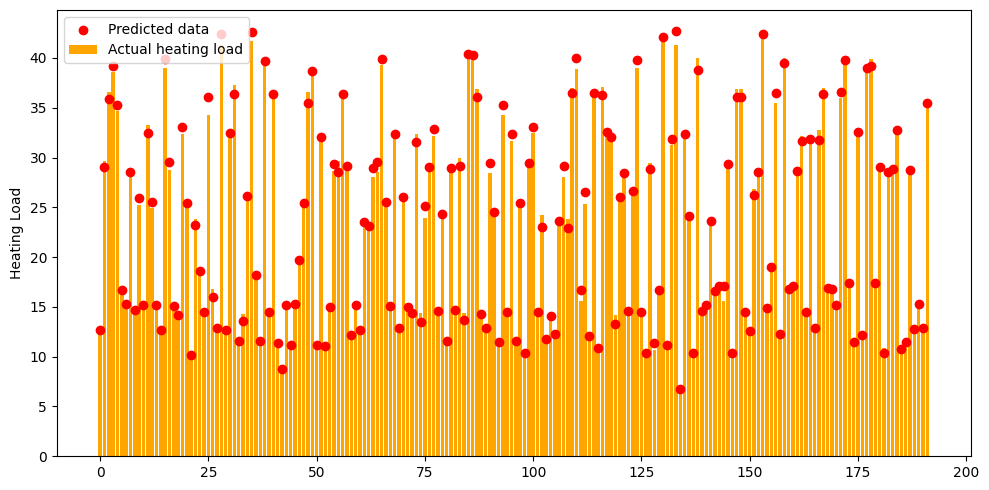

In [50]:
fig, ax = plt.subplots(figsize=(10, 5))

# Plot the actual and predicted heating load
ax.bar(np.arange(len(y_val)), y_val.iloc[:, 0], label='Actual heating load', color='orange')
ax.scatter(np.arange(len(y_pred_RF)), y_pred_RF, label='Predicted data', color='red')
ax.set_ylabel('Heating Load')
ax.legend()

# Show the plot
plt.show()



In [54]:
from joblib import dump

# Save the scikit-learn model to disk
filename = 'finalized_model_multivariate.joblib'
filename_scaler = 'scaler.joblib'
dump(model_RF, filename)
dump(scaler, filename_scaler)


['scaler.joblib']

**6. Conclusions**

- Exploratory data analysis indicates that most input variables exhibit non-Gaussian distribution.

- Based on our evaluation of five machine learning algorithms and a neural network model, we selected Random Forest as the surrogate model for multi-objective optimization due to its high score in cross validation and low Mean Squared Error values.

- The Mean Absolute Error values suggest that the prediction accuracy is generally good, although the ElasticNet algorithm may require further refinement.

- The results indicate that the performance of the Keras Sequential neural network model is comparable to that of other machine learning algorithms, and further hyperparameter tuning may improve its predictive accuracy.

In [55]:
from joblib import load

# Load the scikit-learn model from disk
filename = 'finalized_model_multivariate.joblib'
filename_scaler = 'scaler.joblib'
model_RF = load(filename)
scaler = load(filename_scaler)


In [56]:
# Define the input data as a dictionary
input_data = {
    'Relative Compactness': [0.98],
    'Surface Area': [600],
    'Roof Area': [120],
    'Overall Height': [20],
    'Orientation':  [135],
    'Glazing Area':  [23],
    'Glazing Area Distribution': [7]
}

# Create a DataFrame
X_new = pd.DataFrame(input_data)

# Apply the scaler to the input data
X_new_scaled = scaler.transform(X_new)
X_new_scaled


array([[ 1.        ,  0.29081633,  0.08843537,  4.71428571, 44.33333333,
        57.5       ,  1.4       ]])

In [58]:
# Make predictions
predictions = model_RF.predict(X_new_scaled)

# Print the prediction
print('Predicted heating load:', round(predictions[0],1), "kWh")


Predicted heating load: 33.7 kWh
